In [2]:
import torch
import numpy as np
from PIL import Image
import sys

sys.path.append('/home/coby/Repositories/facearithmetic')

import stylegan3.dnnlib as dnnlib
import stylegan3.legacy as legacy

# 1. Path to your StyleGAN3 .pkl model
network_pkl = 'models/stylegan3-r-ffhqu-256x256.pkl'  # or wherever you placed it

# 2. Load the pre-trained network
print(f'Loading networks from "{network_pkl}"...')
device = torch.device('cuda')  # 'cuda' or 'cpu'
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)
with dnnlib.util.open_url(network_pkl) as f:
    D = legacy.load_network_pkl(f)['D'].to(device)

Loading networks from "models/stylegan3-r-ffhqu-256x256.pkl"...


No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


RuntimeError: No CUDA GPUs are available

Setting up PyTorch plugin "bias_act_plugin"... 

/home/coby/miniconda3/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/home/coby/miniconda3/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


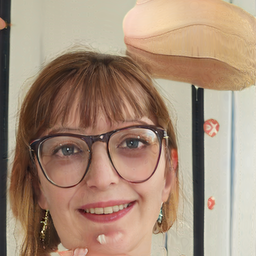

In [2]:
# 3. Sample a random latent vector (z) and optional label (c)
z = torch.randn([1, G.z_dim], device=device)
c = None  # For unconditional models (e.g. FFHQ)
# For class-conditional models, you'd need a valid class or conditioning vector here.

# 4. Generate the image
img = G(z, c, truncation_psi=1.0, noise_mode='const')  # [N, C, H, W]
# StyleGAN typically outputs images in [-1, 1]. Convert to [0, 255] range.

img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8)
img = img[0].permute(1, 2, 0).cpu().numpy()  # [H, W, C]

# 5. Display or save
display(Image.fromarray(img))  # In Colab, you can also do: display(Image.fromarray(img))

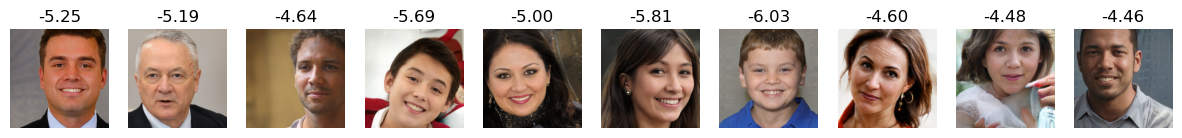

In [19]:
# discriminability experiment
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for i in range(10):
  z = torch.randn([1, G.z_dim], device=device)
  k = G(z, c, truncation_psi=0.7, noise_mode='const')
  img = (k * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = img[0].permute(1, 2, 0).cpu().numpy()
  axs[i].imshow(img)
  axs[i].axis('off')

  d = D(k, c)

  axs[i].set_title(f'{d.item():.2f}')
plt.show()

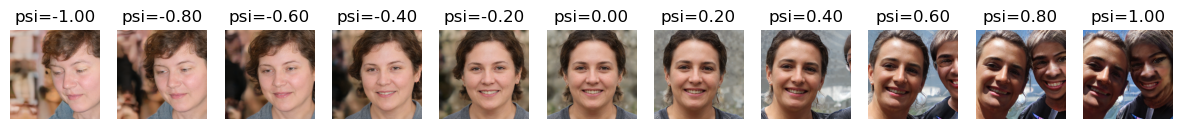

In [10]:
# truncation psi experiment
psis = np.linspace(-1, 1, 11)
fig, axs = plt.subplots(1, 11, figsize=(15, 15))

z = torch.randn([1, G.z_dim], device=device)

for i, psi in enumerate(psis):
  k = G(z, c, truncation_psi=psi, noise_mode='const')
  img = (k * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = img[0].permute(1, 2, 0).cpu().numpy()

  axs[i].imshow(img)
  axs[i].axis('off')
  axs[i].set_title(f'psi={psi:.2f}')

plt.show()

In [11]:
# helper functions
def output_to_img(output):
  img = (output * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = img[0].permute(1, 2, 0).cpu().numpy()
  return img

def gen_img(z, truncation_psi):
  img = G(z, None, truncation_psi=truncation_psi)
  img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = img[0].permute(1, 2, 0).cpu().numpy()
  return img

def interpolate(z1, z2, num_steps):
  steps = []
  for i in range(num_steps):
    t = i / (num_steps - 1)
    z = (z1 * (1 - t)) + (z2 * t)
    steps.append(z)
  return steps

def generate_imgs(zs, truncation_psi):
  imgs = []
  for z in zs:
    imgs.append(gen_img(z, truncation_psi))
  return imgs

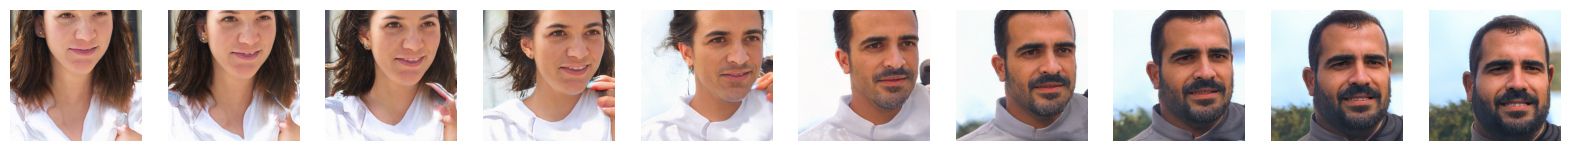

In [16]:
# interpolation experiment
z1 = torch.randn([1, G.z_dim], device=device)
z2 = torch.randn([1, G.z_dim], device=device)
zs = interpolate(z1, z2, 10)
imgs = generate_imgs(zs, 1.0)

fig, axs = plt.subplots(1, len(imgs), figsize=(20, 20))
for i, img in enumerate(imgs):
  axs[i].imshow(img)
  axs[i].axis('off')
plt.show()

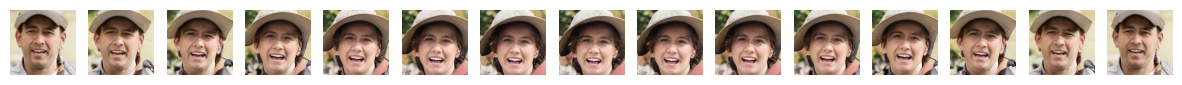

In [ ]:
# sine experiment
center = torch.randn([1, G.z_dim], device=device)
direction = torch.randn([1, G.z_dim], device=device)
steps = 15
ts = torch.linspace(0, np.pi, steps, device=device)
zs = center + torch.stack([torch.sin(t) * direction for t in ts])
imgs = generate_imgs(zs, 0.7)

fig, axs = plt.subplots(1, steps, figsize=(15, 15))
for i, img in enumerate(imgs):
  axs[i].imshow(img)
  axs[i].axis('off')
plt.show()

In [ ]:
# invertor initialization
from copy import deepcopy
import torch.nn as nn

Invertor = deepcopy(D).to(device)
Invertor.b4.out = nn.Linear(512, 512).to(device)

for param in Invertor.parameters():
  param.requires_grad = False
for param in Invertor.b4.out.parameters():
  param.requires_grad = True
for param in Invertor.b4.fc.parameters():
  param.requires_grad = True

# data generator functions
def gen_data(num_samples, G=G):
    z_samps = torch.randn(num_samples, 512, device=device)
    x_samps = G(z_samps, None)
    return x_samps, z_samps

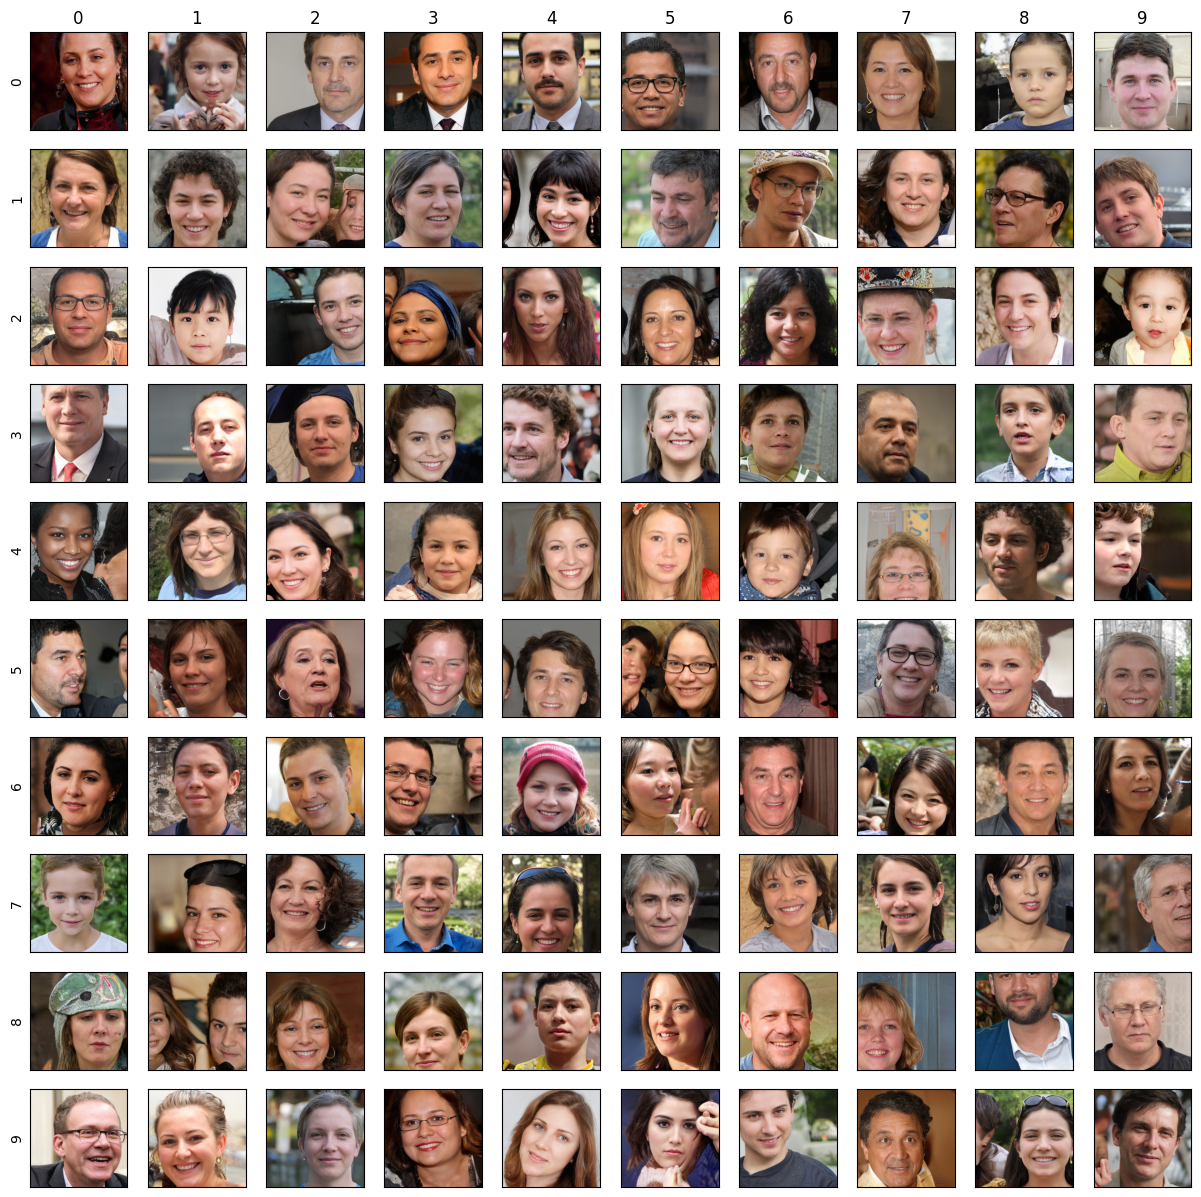

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(15,15))
codes = torch.empty((10, 10, 1, G.z_dim)).to(device)
for i in range(10):
  for j in range(10):
    z = torch.randn([1, G.z_dim], device=device)
    k = G(z, c, truncation_psi=0.7, noise_mode='const')
    codes[i, j] = z
    axs[i][j].imshow(output_to_img(k))
    axs[i][j].set_xticks([])
    axs[i][j].set_yticks([])
    if i == 0:
      axs[i][j].set_title(f'{j}')
    if j == 0:
      axs[i][j].set_ylabel(f'{i}')
plt.show()

array([[[  4,   2,   2],
        [  5,   3,   2],
        [  7,   4,   3],
        ...,
        [ 10,  10,   9],
        [  9,   9,   8],
        [ 11,  11,   9]],

       [[  4,   2,   2],
        [  5,   4,   2],
        [ 10,   3,   3],
        ...,
        [ 10,  10,   8],
        [  9,  10,   7],
        [ 10,  10,   8]],

       [[  4,   3,   2],
        [  7,   3,   2],
        [ 12,   4,   3],
        ...,
        [ 11,  10,   8],
        [ 10,   9,   7],
        [  9,   8,   7]],

       ...,

       [[ 80,  32,   9],
        [ 75,  36,  11],
        [ 90,  46,  24],
        ...,
        [  6,   0,   0],
        [  6,   0,   0],
        [  6,   0,   0]],

       [[108,  65,  43],
        [ 86,  38,  15],
        [ 75,  27,   7],
        ...,
        [  6,   0,   0],
        [  6,   0,   0],
        [  6,   0,   0]],

       [[129,  86,  63],
        [125,  74,  42],
        [106,  61,  34],
        ...,
        [  6,   0,   0],
        [  6,   0,   0],
        [  6,   0,   0]]], dtype=uint8)
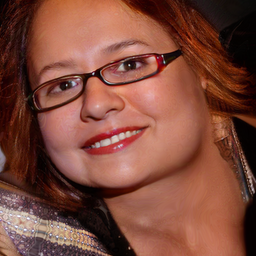

In [ ]:
code = codes[9, 3]
out = G(code, None)
output_to_img(out)

In [ ]:
# data installation
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denislukovnikov/ffhq256-images-only")

print("Path to dataset files:", path)

100%|██████████| 6.91G/6.91G [01:48<00:00, 68.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/denislukovnikov/ffhq256-images-only/versions/1


In [ ]:
# data prep
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os

class FFHQDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")  # Ensure the image is in RGB format
        if self.transform:
            image = self.transform(image)
        return image

data = FFHQDataset(root_dir='/root/.cache/kagglehub/datasets/denislukovnikov/ffhq256-images-only/versions/1/ffhq256',
                   transform=transforms.Compose([
                       transforms.Resize((256, 256)),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
data_loader = DataLoader(data, batch_size=16, shuffle=True)

In [ ]:
batch_images = torch.randn(16, 3, 256, 256)  # Simulate a batch of 4 images
pred_codes = Invertor(batch_images.to(device), None)
print(f"Predicted codes shape: {pred_codes.shape}")  # Should be [4, latent_dim]

Predicted codes shape: torch.Size([16, 512])


In [ ]:
# training loop
import torch.optim as optim

optimizer = optim.Adam(Invertor.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

num_epochs = 10

Invertor.train()

for epoch in range(num_epochs):
    for batch_idx, images in enumerate(data_loader):
        images = images.to(device)
        # print(f"Input images shape: {images.shape}")
        optimizer.zero_grad()
        pred_codes = Invertor(images, None)
        # print(f"Predicted codes shape: {pred_codes.shape}")
        pred_images = G(pred_codes, None)
        loss = loss_fn(pred_images, images)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(data_loader)}, Loss: {loss.item()}")

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

Epoch 1/10, Batch 0/4375, Loss: 0.24301698803901672
Epoch 1/10, Batch 10/4375, Loss: 0.2604386508464813
Epoch 1/10, Batch 20/4375, Loss: 0.2984605133533478
Epoch 1/10, Batch 30/4375, Loss: 0.21991054713726044
Epoch 1/10, Batch 40/4375, Loss: 0.26033347845077515
Epoch 1/10, Batch 50/4375, Loss: 0.30937886238098145
Epoch 1/10, Batch 60/4375, Loss: 0.26798874139785767
Epoch 1/10, Batch 70/4375, Loss: 0.2901155948638916
Epoch 1/10, Batch 80/4375, Loss: 0.25973793864250183
Epoch 1/10, Batch 90/4375, Loss: 0.266338974237442
Epoch 1/10, Batch 100/4375, Loss: 0.2505824565887451
Epoch 1/10, Batch 110/4375, Loss: 0.2775445580482483
Epoch 1/10, Batch 120/4375, Loss: 0.2927737832069397
Epoch 1/10, Batch 130/4375, Loss: 0.28004634380340576
Epoch 1/10, Batch 140/4375, Loss: 0.280620813369751


KeyboardInterrupt: 

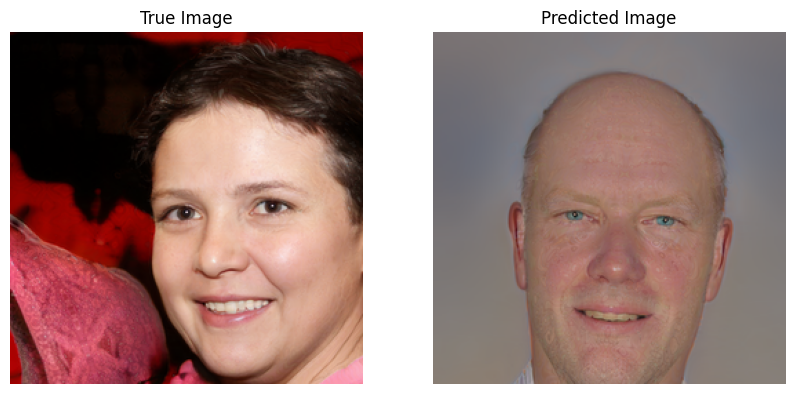

In [ ]:
z = torch.randn([1, G.z_dim], device=device)
k = G(z, c, truncation_psi=0.7, noise_mode='const')
pred_z = Invertor(k, None)
pred_k = G(pred_z, c, truncation_psi=0.7, noise_mode='const')
true_img = output_to_img(k)
pred_img = output_to_img(pred_k)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(true_img)
axs[0].axis('off')
axs[0].set_title('True Image')
axs[1].imshow(pred_img)
axs[1].axis('off')
axs[1].set_title('Predicted Image')
plt.show()

In [ ]:
pred_k - k

tensor([[[[ 0.0532,  0.0851,  0.1318,  ..., -0.8120, -0.7695, -0.7649],
          [ 0.0377,  0.0654,  0.1045,  ..., -0.7830, -0.7258, -0.6746],
          [ 0.0319,  0.0497,  0.0819,  ..., -0.7354, -0.6895, -0.6270],
          ...,
          [-0.3477, -0.3042, -0.1572,  ..., -1.1484, -1.2090, -1.2307],
          [-0.3032, -0.3735, -0.3208,  ..., -1.2104, -1.2280, -1.2695],
          [-0.2271, -0.2998, -0.2881,  ..., -1.0911, -1.0684, -1.1919]],

         [[ 0.1769,  0.2017,  0.2361,  ..., -0.7363, -0.7216, -0.7263],
          [ 0.1642,  0.1829,  0.2062,  ..., -0.6986, -0.6842, -0.6578],
          [ 0.1527,  0.1624,  0.1821,  ..., -0.6589, -0.6398, -0.6122],
          ...,
          [-0.1860, -0.1748, -0.0312,  ..., -1.1008, -1.2051, -1.2297],
          [-0.1177, -0.2058, -0.1846,  ..., -1.2061, -1.2373, -1.2637],
          [-0.0469, -0.1055, -0.1216,  ..., -1.0613, -1.0295, -1.1624]],

         [[-0.0889, -0.0757, -0.0356,  ..., -0.9375, -0.9363, -0.9458],
          [-0.1128, -0.0967, -